In [1]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [2]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in [0, 4]:
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

20

In [3]:
images = []
for sample_idx in samples_idx.flatten():
    images.append(mndata.train_images[sample_idx])

images = np.array(images, dtype='float')
images = images / 255
images.shape

(20, 784)

In [4]:
def simple_plot(T: list):
    T_arr = np.array(T, dtype=float)

    fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
    axs.plot(np.arange(T_arr.size), T_arr)


    plt.show()

In [5]:
from typing import Literal

def show_image(image: ndarray, cmap: Literal['bone', 'Greys'] = 'bone'):
    # figure(figsize=(15, 10))

    imshow(np.array(image),
        interpolation='none',
        aspect='equal',
        cmap=cmap,
        )

    axis("off")

    show()

In [6]:
def get_discount_matrix(size, rev = False, cor_supr_size=0):
    a = np.arange(size)
    if rev:
        a = np.abs(np.abs(a - a[np.newaxis].T) - np.max(a))
    else:
        a = np.abs(a - a[np.newaxis].T)
    np.fill_diagonal(a, 0)

    if cor_supr_size > 0:
        a[:cor_supr_size] = 0
        a[:, 0:cor_supr_size] = 0
        a[-cor_supr_size:] = 0
        a[:, -cor_supr_size:] = 0

    return a

# a = get_discount_matrix(10, rev=True, cor_supr_size=2)
# a = np.array(a, dtype='float')
# # a[:, 0:2] = 0
# print(a)
# show_image(a, cmap='Greys')

In [7]:
def show_images_table(images_2d: ndarray, img_side: int = 28, row_size=10):
    column_size = int(images.shape[0] / row_size)

    shaped_images = images_2d.reshape(column_size, row_size, img_side, img_side)
    shaped_images = shaped_images.swapaxes(1, 2).reshape(column_size*img_side, row_size*img_side)

    figure(figsize=(15, 10))

    imshow(shaped_images,
           interpolation='none',
           aspect='equal',
           cmap='bone',
           )
    
    axis("off")

# show_images_table(images_2d=images)
images.shape

(20, 784)

In [8]:
def infer(input: ndarray, W: ndarray, iter_cnt: int):
    I = np.copy(input)

    O = np.zeros(I.size)

    T = []
    OST = []

    for iter_idx in range(iter_cnt):
        DO = np.exp((I - W)**2 * -20.0)
        O += np.sum(DO, axis=1)

        O = O ** 2

        # inhibition
        O[np.where(O < np.mean(O))] = 0

        # recur
        O /= np.max(O)

        I = np.copy(O)

        # stats
        # t = np.sum(O > 0)
        t = np.mean(O)
        # t = np.sum(O)

        T.append(t)

        OST.append(np.copy(O))
    
    return T, OST


- TODO: temporal W during relaxation, then update real W
- TODO: statistical (axonal) weights. Update S during relaxing? Energy is amount of active Neurons or dendrite error?
- TODO: Temperatura - increase then decrease.
- TODO: Dendrites' stats weight.
- TODO: weight decay
- TODO: Neuron threshold

- TODO: associative (serotonin) weights update?

In [9]:
def relax(I: ndarray,
          inp_S: ndarray,
          W: ndarray,
          inp_NS: ndarray,
          NW: ndarray,
          inp_PS: ndarray,
          inp_NPS: ndarray,
          TR: ndarray,
          iter_cnt=100,
          ddsc=1.0,
          s_axis = 0,
          eps0 = 0.01,
          thre_coef = 1.0,
          S_C: Literal['eps', 'R', None] = None,
          ):
    S = np.copy(inp_S)
    NS = np.copy(inp_NS)
    O = np.zeros(S.shape[0])

    prev_S = np.copy(inp_S)
    prev_NS = np.copy(inp_NS)
    prev_O = np.copy(O)
    prev_SO = np.zeros(S.shape)
    prev_NSO = np.zeros(NS.shape)

    SP = []
    MP = []
    CP = []
    DP = []

    OST = []

    is_break = False

    eq_cp_cnt = 0

    for iter_idx in range(iter_cnt):
        eps = (iter_cnt - iter_idx) * eps0

        n = 1

        if np.sum(I > TR * thre_coef) > 0:
            I *= (I > TR * thre_coef)

        # infer
        np.fill_diagonal(S, 0)
        SO = I * S
        DO = np.exp((SO - W)**2 * -20.0)
        DO *= inp_PS
        np.fill_diagonal(DO, 0)
        dO = np.sum(DO, axis=1)
        # dO **= n
        # dO /= np.max(dO)
        # O += dO

        # inhibition infer
        np.fill_diagonal(NS, 0)
        NSO = I * NS
        NDO = np.exp((NSO - NW)**2 * -20.0)
        NDO *= inp_NPS
        np.fill_diagonal(NDO, 0)
        dNO = np.sum(NDO, axis=1)
        # dNO **= n
        # dNO /= np.max(dNO)
        # O -= dNO

        # infer iter update
        adO = (dO - dNO)
        sgn_adO = np.sign(adO)
        adO **= n
        adO = sgn_adO * np.abs(adO)
        adO /= np.max(np.abs(adO))
        # O += np.sign(adO) * (adO ** n)
        O += adO

        # inhibition
        O[np.where(O < 0)] = 0

        # TR
        # O[np.where(O < TR)] = 0
        # mask_TR = (O > TR * thre_coef)
        # print(f'{mask_TR=}')

        # threshold
        # thre = 0.5
        # O[np.where(O > thre)] = thre

        # train inh stats S
        R = (np.random.rand(S.shape[0], S.shape[1]) * eps0)
        if np.max(O) > 0:
            NO = O / np.max(O)
        else:
            NO = O
        mask_TR = (NO > TR * thre_coef)
        NO *= mask_TR
        if S_C == 'R':
            ddS = NO * I[np.newaxis].T * R
        if S_C == 'eps':
            ddS = NO * I[np.newaxis].T * eps
        else:
            ddS = NO * I[np.newaxis].T

        dNS = np.copy(ddS)

        # inh update
        NS += dNS**ddsc

        # train stats S
        dS = np.copy(ddS)

        # update
        S += dS**ddsc

        # stats
        mask_O = (O > 0)[np.newaxis].T
        SP.append(np.sum(O))
        MP.append(np.mean(O[np.where(O > 0)]))
        CP.append(np.sum(O > 0))
        DP.append(np.mean(np.abs(SO - W) * mask_O) + np.mean(np.abs(NSO - NW) * mask_O))

        # recur
        O /= np.max(O)

        I = np.copy(O)
        
        print(f'{np.sum(mask_TR)=}')

        # print(f'{I=}')

        max_S = np.max(S, axis=s_axis)
        if np.max(max_S) > 1:
            # print(f'{np.max(max_S)=}')
            if s_axis == 1:
                S /= max_S[np.newaxis].T
            else:
                S /= max_S
            # print(f'{np.max(S)=}')

        max_NS = np.max(NS, axis=s_axis)
        if np.max(max_NS) > 1:
            # print(f'{np.max(max_NS)=}')
            if s_axis == 1:
                NS /= max_NS[np.newaxis].T
            else:
                NS /= max_NS

        # prev
        if not is_break:
            prev_S = np.copy(S)
            prev_NS = np.copy(NS)
            prev_O = np.copy(O)
            prev_SO = np.copy(SO)
            prev_NSO = np.copy(NSO)

        # stats
        OST.append(np.copy(O))

        # break
        if iter_idx > 1 and MP[iter_idx-1] > MP[iter_idx] and MP[iter_idx-1] > MP[iter_idx - 2]:
            # break
            depth = (MP[iter_idx-1] - MP[iter_idx]) + (MP[iter_idx-1] - MP[iter_idx - 2])
            # print(f'Mean Out break: {iter_idx-1=} {depth=}')
            # break
        
        if iter_idx > 1 and DP[iter_idx-1] < DP[iter_idx] and DP[iter_idx-1] < DP[iter_idx - 2]:
            depth = (DP[iter_idx] - DP[iter_idx-1]) + (DP[iter_idx - 2] - DP[iter_idx-1])
            # print(f'Err break: {iter_idx-1=} {depth=} {DP[iter_idx-1]=} {CP[iter_idx-1]=}')
            # break
            # is_break = True
        
        if iter_idx > 1 and CP[iter_idx-1] == CP[iter_idx]:
            eq_cp_cnt += 1
        else:
            eq_cp_cnt = 0
        
        eq_cp = 10
        if eq_cp_cnt == eq_cp:
            print(f'CP break: {iter_idx=} {CP[iter_idx]=}')
            break
            # is_break = True

    return prev_S, prev_NS, prev_O, prev_SO, prev_NSO, SP, MP, CP, DP, OST


In [10]:
a = np.array([1,2,3,4,5,6,7,8])
b = a*2
print(a)
print(b)
l4a = a > 4
a[l4a] = b[l4a] * 2 - a[l4a]
g4a = a <= 4
a[g4a] = b[g4a]
a[g4a]

[1 2 3 4 5 6 7 8]
[ 2  4  6  8 10 12 14 16]


array([2, 4, 6, 8])

In [11]:
def train_TR(TR: ndarray, cnt_TR: ndarray, O: ndarray):
    if np.sum(TR > 0) == 0:
        new_TR = np.copy(O) 
    else:
        new_TR = TR + ((O - TR) / cnt_TR)

    cnt_TR += 1

    return new_TR, cnt_TR

In [12]:
layer_size = n_mnist_pixels

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size)
NW = np.random.rand(O.size, I.size)

TR = np.zeros(O.size)
cnt_TR = np.zeros(O.size)

s_c = 0.01
S = np.random.rand(O.size, I.size) * s_c
NS = np.random.rand(O.size, I.size) * s_c

ps_c = 0.01
PS = np.random.rand(O.size, I.size) * ps_c
NPS = np.random.rand(O.size, I.size) * ps_c

print('W', W.shape, W.max(), W.min(), np.median(W))
print(f'{S.shape=} {S.max()=} {S.min()=} {np.median(S)=}')

thre_S = 0.05

iter_cnt = 100 * 1

epoch_cnt = 100

eps0 = 0.0001
# eps = eps0

DP = []
CP = []
SP = []
MP = []

images_idx = [10, 0]
# images_idx = [0]

ATTR = {}
for img_idx in images_idx:
    ATTR.setdefault(img_idx, [])

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    img_O = []

    for img_idx in images_idx:
        img = images[img_idx]

        I = np.copy(img)
        print(f'{I.shape=} {I.max()=} {I.min()=} {np.median(I)=}')

        prev_S, prev_NS, O, SO, NSO, rlx_SP, rlx_MP, rlx_CP, rlx_DP, OST = relax(I=I,
                                                                                 inp_S=S,
                                                                                 W=W,
                                                                                 inp_NS=NS,
                                                                                 NW=NW,
                                                                                 inp_PS=PS,
                                                                                 inp_NPS=NPS,
                                                                                 TR=TR,
                                                                                 iter_cnt=100,
                                                                                 ddsc=1.0,
                                                                                 s_axis=0,
                                                                                 S_C=None,
                                                                                 eps0=0.001,
                                                                                 thre_coef=1.0)
        # set TR
        mask_O = (O > TR)[np.newaxis].T
        TR_O = O * (O > TR)
        
        # print(f'{img_idx=} {np.where(O > TR)=}')

        # TR threshold train
        TR, cnt_TR = train_TR(TR, cnt_TR, TR_O)
        # print(f'{TR=} {cnt_TR=} {mask_O=} {O=}')
        O = TR_O
        
        threshold = np.mean(O)
        img_O.append(O)

        excit_mask = (O > threshold)

        # stats train
        ddS = O * I[np.newaxis].T * eps

        # S train
        dS = np.copy(ddS)
        dS *= excit_mask[np.newaxis].T
        dS *= excit_mask

        # train
        dW = (SO - W) * eps
        dS *= excit_mask[np.newaxis].T
        dS *= excit_mask

        # update
        W += dW
        # S += dS
        PS += dS

        inh_mask = np.bitwise_and(O <= threshold, O > 0)

        # inh S train
        dNS = np.copy(ddS)
        dNS *= inh_mask[np.newaxis].T
        dNS *= excit_mask

        # inh train
        dNW = (NSO - NW) * eps
        # dNW *= mask_O
        dNW *= inh_mask[np.newaxis].T
        dNW *= excit_mask

        # inh update
        NW += dNW
        # NS += dNS
        NPS += dNS

        # stats
        if img_idx == 0:
            DP.extend(rlx_DP)
            CP.extend(rlx_CP)
            SP.extend(rlx_SP)
            MP.extend(rlx_MP)

        ATTR[img_idx].append(OST[-2])

        # recur S
        # max_S = np.max(S, axis=0)
        # if np.max(max_S) > 1:
        #     S /= max_S

        # max_NS = np.max(NS, axis=0)
        # if np.max(max_NS) > 1:
        #     NS /= max_NS
        
        # recur dendritic S
        max_PS = np.max(PS, axis=1)
        if np.max(max_PS) > 1:
            PS /= max_PS[np.newaxis].T

        max_NPS = np.max(NPS, axis=1)
        if np.max(max_NPS) > 1:
            NPS /= max_NPS[np.newaxis].T
    
    if ATTR.get(10) and ATTR.get(0):
        attr_diff = np.sum(np.abs(ATTR[10][epoch_idx] - ATTR[0][epoch_idx]))
        print(f'{attr_diff=}')

print('W', W.shape, W.max(), W.min(), np.median(W))
print(f'{S.shape=} {S.max()=} {S.min()=} {np.median(S)=}')
print(f'{PS.shape=} {PS.max()=} {PS.min()=} {np.median(PS)=}')


W (784, 784) 0.9999992672689711 3.0328389738487616e-06 0.500140491101631
S.shape=(784, 784) S.max()=0.009999940690012137 S.min()=3.0337899303845007e-10 np.median(S)=0.005000745614217055
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
np.sum(mask_TR)=385
np.sum(mask_TR)=387
np.sum(mask_TR)=385
np.sum(mask_TR)=382
np.sum(mask_TR)=378
np.sum(mask_TR)=378
np.sum(mask_TR)=382
np.sum(mask_TR)=385
np.sum(mask_TR)=385
np.sum(mask_TR)=386
np.sum(mask_TR)=386
np.sum(mask_TR)=385
np.sum(mask_TR)=386
np.sum(mask_TR)=387
np.sum(mask_TR)=387
np.sum(mask_TR)=385
np.sum(mask_TR)=384
np.sum(mask_TR)=384
np.sum(mask_TR)=384
np.sum(mask_TR)=384
np.sum(mask_TR)=384
np.sum(mask_TR)=384
np.sum(mask_TR)=384
np.sum(mask_TR)=384
np.sum(mask_TR)=385
np.sum(mask_TR)=386
np.sum(mask_TR)=385
np.sum(mask_TR)=385
np.sum(mask_TR)=385
np.sum(mask_TR)=385
np.sum(mask_TR)=385
np.sum(mask_TR)=385
np.sum(mask_TR)=385
np.sum(mask_TR)=385
np.sum(mask_TR)=385
np.sum(mask_TR)=385
np.sum(mask_TR)=385
CP break: iter_idx

np.sum(o>0)=629
np.sum(o>0)=742


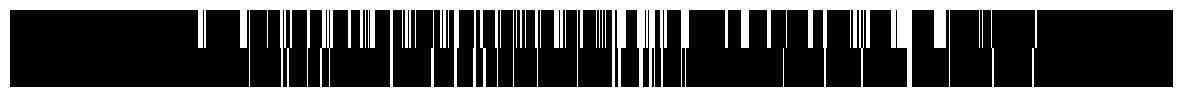

In [13]:
for o_idx, o in enumerate(img_O):
    print(f'{np.sum(o>0)=}')
    img_O[o_idx] = (o > 0)

figure(figsize=(15, 1))

imshow(np.array(img_O),
    interpolation='none',
    aspect='auto',
    cmap='Greys',
    )

axis("off")

show()

CP[-1]=781


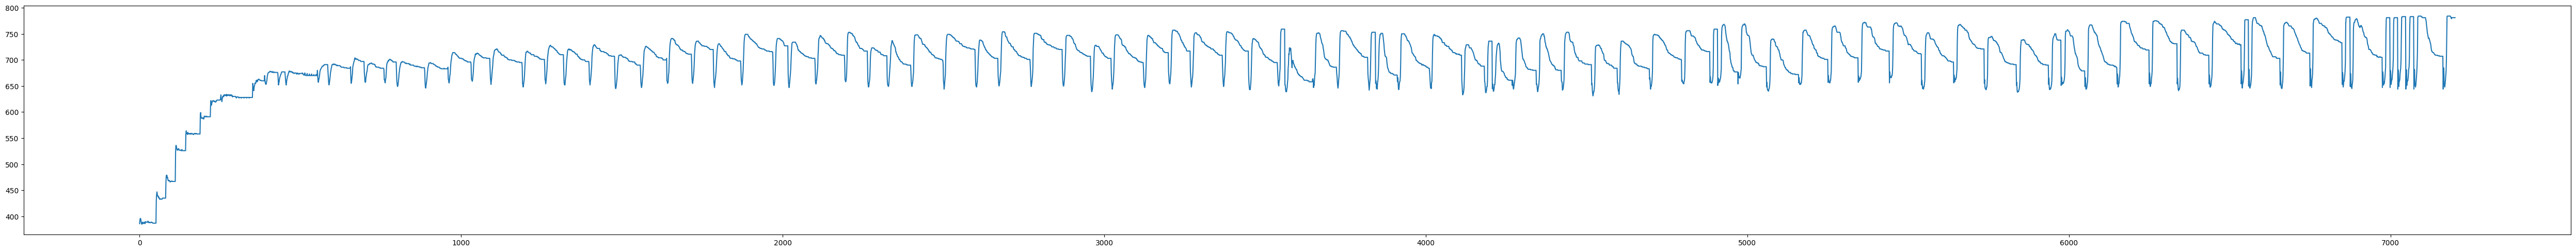

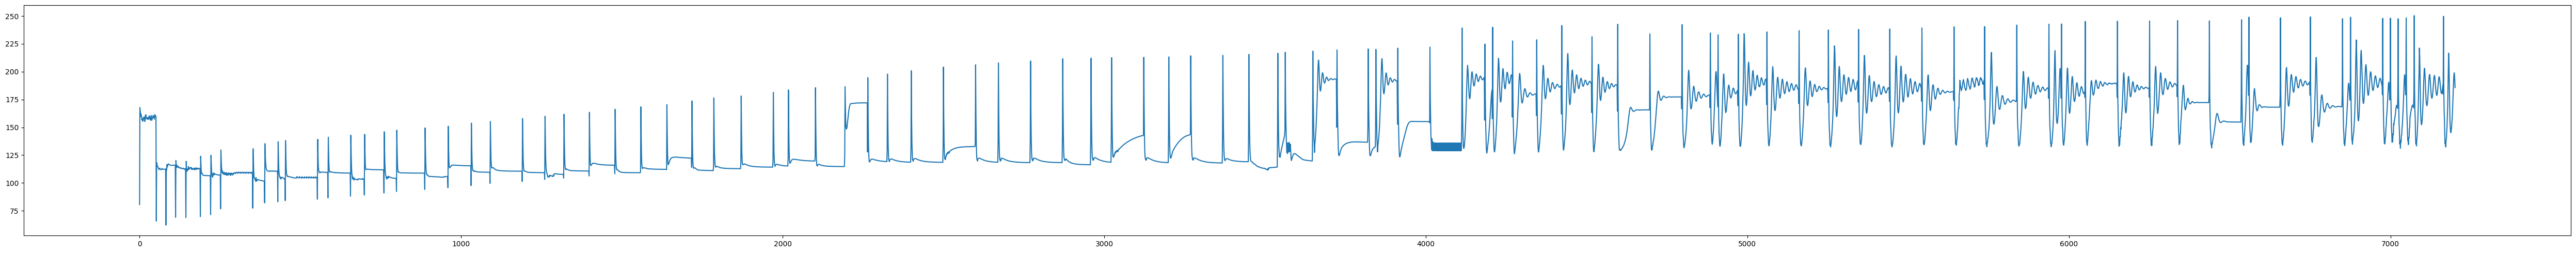

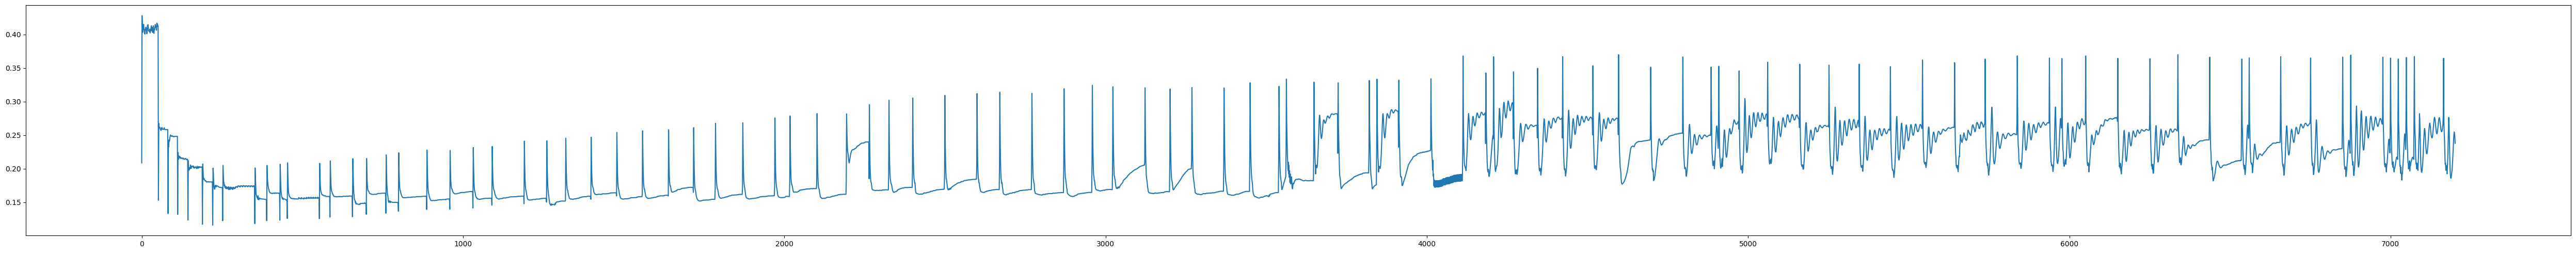

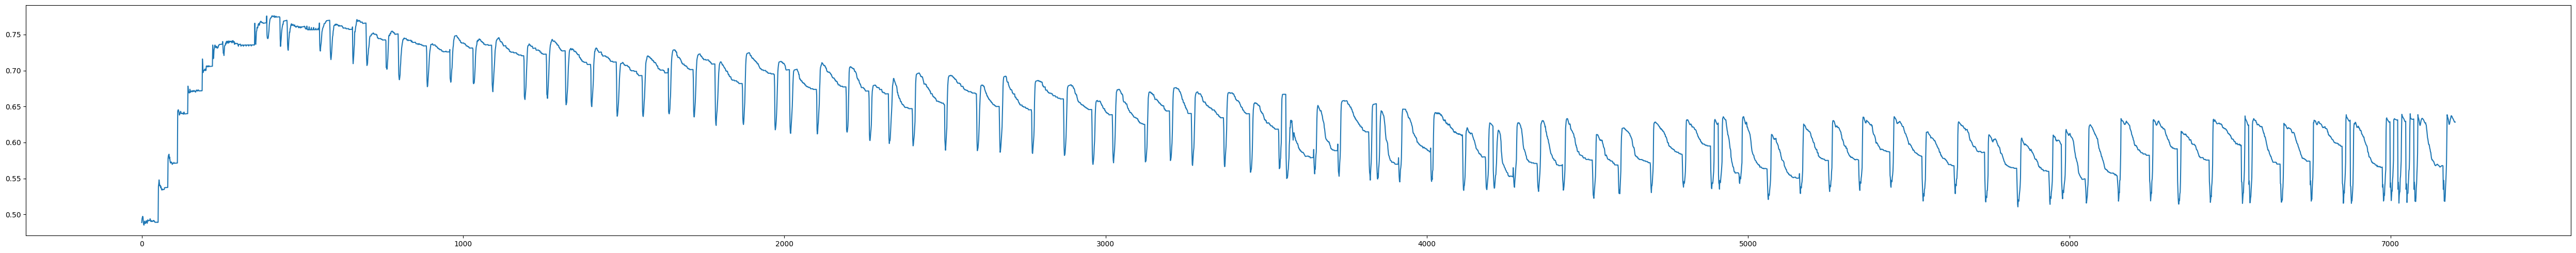

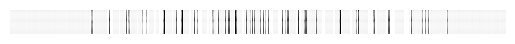

In [14]:
print(f'{CP[-1]=}')
simple_plot(T=CP)
simple_plot(T=SP)
simple_plot(T=MP)
simple_plot(T=DP)

show_image(image=OST, cmap='Greys')

In [15]:
SP[70:]

[112.9834460940279,
 112.64010107328139,
 112.3821498864587,
 112.32395112208698,
 112.25886285887835,
 112.23800294948609,
 112.27574296233522,
 112.35677247261381,
 112.33145920927748,
 112.32484708940022,
 112.34251302793875,
 112.34121424186117,
 62.04691794874217,
 113.07666206070886,
 111.3044867103707,
 116.39931336961135,
 114.12202114648139,
 115.31065644726912,
 116.48740285465595,
 117.00191677742296,
 117.08842567544954,
 116.7351235045451,
 116.47239535563598,
 116.32156624620758,
 116.182964847511,
 116.04784479379099,
 115.9454446046533,
 115.87297639101381,
 115.82063899944171,
 115.79722006693825,
 115.79407200037079,
 115.80025646659408,
 115.81091641101312,
 115.82251210725042,
 115.83318126631697,
 115.8451251872798,
 115.85708785352139,
 115.8684818688514,
 115.87990269810405,
 115.89117476098907,
 115.90233624252386,
 115.9131614009021,
 69.05728042166837,
 120.18536231902482,
 115.3468265830055,
 113.89448687385098,
 115.99500277593222,
 114.77732982019721,
 114.

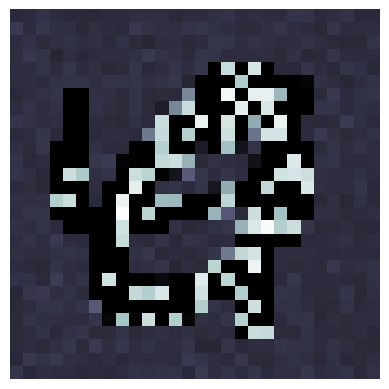

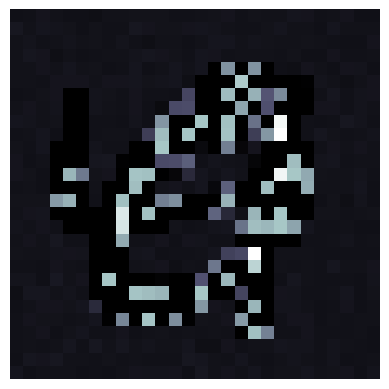

In [16]:
al = np.copy(OST[0])
al = al.reshape(img_side, img_side)
show_image(al)

al = np.copy(OST[-2])
al = al.reshape(img_side, img_side)
show_image(al)

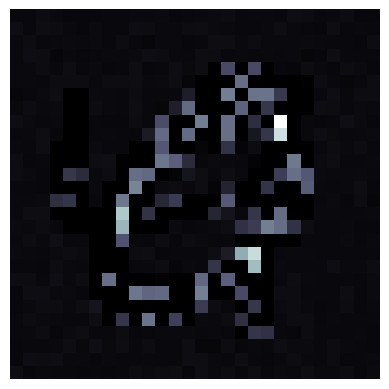

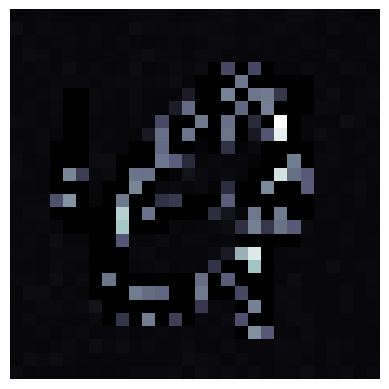

In [19]:
show_image(image=ATTR[0][50].reshape(img_side, img_side))
show_image(image=ATTR[10][50].reshape(img_side, img_side))

In [18]:
a1 = np.sum(np.abs(ATTR[0][0] - ATTR[10][0]))
a2 = np.sum(np.abs(ATTR[0][50] - ATTR[10][50]))
a3 = np.sum(np.abs(ATTR[0][99] - ATTR[10][99]))
print(a1, a2, a3)


43.96943897123152 8.304162474334689 18.150093941163462
